In [ ]:
#https://github.com/SamQLuong/SHRED-Model-Analysis

In [1]:
!git clone https://github.com/shervinsahba/pyshred

fatal: destination path 'pyshred' already exists and is not an empty directory.


In [2]:
%cd pyshred

/content/pyshred


In [3]:
import numpy as np
from processdata import load_data
from processdata import TimeSeriesDataset
import models
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [4]:
def add_gaussian_noise(data, mean, std_dev):
    noise = np.random.normal(mean, std_dev, size=data.shape)
    noisy_data = data + noise
    return noisy_data

In [12]:
num_sensors = 3
lags = 52
load_X = load_data('SST')
n = load_X.shape[0]
m = load_X.shape[1]
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

mean = 0
std_dev = 0.0

load_X = add_gaussian_noise(load_X, mean, std_dev)

In [13]:
train_indices = np.random.choice(n - lags, size=1000, replace=False)
mask = np.ones(n - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[::2]
test_indices = valid_test_indices[1::2]

In [14]:
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

### Generate input sequences to a SHRED model
all_data_in = np.zeros((n - lags, lags, num_sensors))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

### -1 to have output be at the same time as final sensor measurements
train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

In [15]:
shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, verbose=True, patience=5)

epoch: 260 valid_error: tensor(0.2965, device='cuda:0'):  26%|██▌       | 259/1000 [00:42<02:00,  6.16it/s]


In [16]:
test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
print(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

0.6456031


In [17]:
from processdata import load_full_SST

# SST data with world map indices for plotting
full_SST, sst_locs = load_full_SST()
full_test_truth = full_SST[test_indices, :]

# replacing SST data with our reconstruction
full_test_recon = full_test_truth.copy()
full_test_recon[:,sst_locs] = test_recons

# reshaping to 2d frames
for x in [full_test_truth, full_test_recon]:
    x.resize(len(x),180,360)

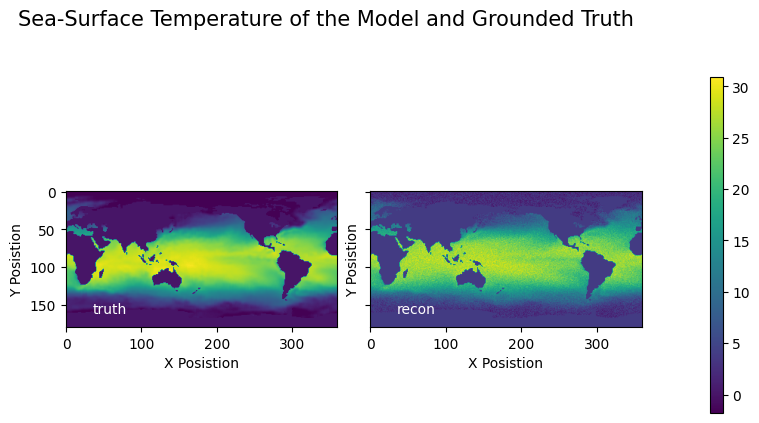

In [18]:
plotdata = [full_test_truth, full_test_recon]
labels = ['truth','recon']
fig, ax = plt.subplots(1,2,constrained_layout=True,sharey=True)
fig.suptitle('Sea-Surface Temperature of the Model and Grounded Truth', fontsize = 15)
images = []
for axis,p,label in zip(ax, plotdata, labels):
    axis.set_xlabel('X Posistion')
    axis.set_ylabel('Y Posistion')
    img = axis.imshow(p[0])
    axis.set_aspect('equal')
    axis.text(0.1,0.1,label,color='w',transform=axis.transAxes)
    images.append(img)
    
cax = fig.add_axes([1.1, 0.15, 0.02, 0.7])
fig.colorbar(images[0], cax=cax)